# Leukimia classification

> Dataset : https://www.kaggle.com/datasets/andrewmvd/leukemia-classification
>
> Author -- <cite>Adela-Bianca Surca</cite>

The classification is effectuated with a convolutional neural network that needs to differentiate normal cells from leukimia blast

### Table of Contents
* [Setup](#setup)
* [Utilities](#util)
* [Data preprocesing](#pre)
    * [Loading the data](#load)
    * [Visualisation of the data](#visu)
    * [Preprocessing](#process)
* [Model](#model)
* [Training the model](#training)
* [Result](#result)

## Setup <a class="anchor" id="setup"></a>

In [ ]:
#To search folders
import glob

#To plot graphs
import matplotlib.pyplot as plt

#To manipulate arrays
import numpy as np

#To manipulate dataframe
import pandas as pd

#To manipulate images
from skimage.io import imread

#To instantiate a convolutional neural network
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler

#To compute statistics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import shuffle

#To create waiting bar in the terminal for loops
from tqdm import tqdm

#To compute mathematical function
from math import floor


To load the data from google colab, the drive library is needed

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Utility Function <a class="anchor" id="util"></a>

In [ ]:
# Plot the training and validation accuracy and loss
# Find which epoch had the best result for the accuracy and the loss
# Based on the 'trainin_data' and the 'start_epoch' which is the epoch at
# which we want the graph to start
# @author = Gerry - https://www.kaggle.com/code/gpiosenka/leukemia-f1-test-score-97/notebook
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g'load,label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

## Data preprocessing <a class="anchor" id="pre"></a>

The model has been train on the GPU of google collab. 

The following path are linked to the different image from the training set

### Loading the data <a class="anchor" id="load"></a>

In [3]:
#Data of cells infected by leukimia
train_dataset_0_all = glob.glob('./gdrive/MyDrive/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_1_all = glob.glob('./gdrive/MyDrive/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')

#Data of healthy cells
train_dataset_0_hem = glob.glob('./gdrive/MyDrive/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_hem = glob.glob('./gdrive/MyDrive/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')

In [4]:
#Load the validation data
valid_data = pd.read_csv('./gdrive/MyDrive/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
print(valid_data)

                Patient_ID new_names  labels
0      UID_57_29_1_all.bmp     1.bmp       1
1      UID_57_22_2_all.bmp     2.bmp       1
2      UID_57_31_3_all.bmp     3.bmp       1
3     UID_H49_35_1_hem.bmp     4.bmp       0
4      UID_58_6_13_all.bmp     5.bmp       1
...                    ...       ...     ...
1862   UID_54_33_1_all.bmp  1863.bmp       1
1863   UID_55_24_1_all.bmp  1864.bmp       1
1864  UID_H32_20_1_hem.bmp  1865.bmp       0
1865   UID_54_30_2_all.bmp  1866.bmp       1
1866   UID_66_10_3_all.bmp  1867.bmp       1

[1867 rows x 3 columns]


In [5]:
#Create lists for healthy and infected cells
A = []
H = []

A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)


H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)

# Transforming the list into arrays
A = np.array(A)
H = np.array(H)

### Visualisation of the data <a class="anchor" id="visu"></a>

100%|██████████| 5/5 [00:00<00:00, 357.06it/s]


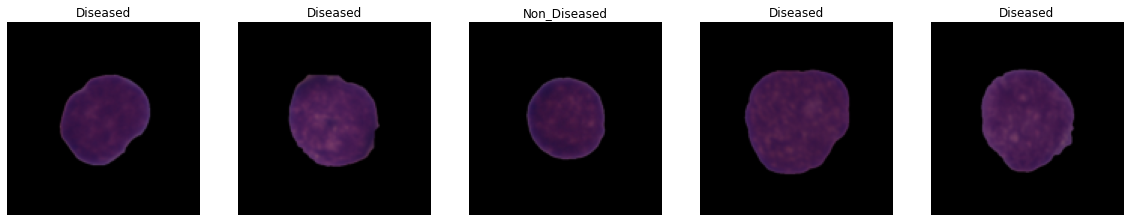

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')

### Preprocessing  <a class="anchor" id="process"></a>

In [6]:
#Preprocess the tra# Build model.ining data
#Combine the image into one list and resize the image into 128x128 pixels
#And create the labels accordingly
Label = []
Image = []
# Progress bar
for i in tqdm(range(0, len(A))):
    img = imread(A[i])
    img = resize(img, (128, 128)) #pk resize a 128 sur 128
    Image.append(img)
    Label.append(1)

# Progress bar
for i in tqdm(range(0, len(H))):
    img = imread(H[i])
    img = resize(img, (128, 128))
    Image.append(img)
    Label.append(0)

#Create list for the image and the label
Image = np.array(Image)
Label = np.array(Label)

#Shuffle the data with a random_state to be able to reproduce the same results
Image, Label = shuffle(Image, Label, random_state=40) 

100%|██████████| 2293/2293 [09:20<00:00,  4.09it/s]


In [7]:
#Preprocess the validation data
X_val = []
for image_name in valid_data.new_names:
    # Loading images
    img = imread('./gdrive/MyDrive/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/' + image_name)
    # Resizing
    img = resize(img, (128, 128))

    X_val.append(img)

In [8]:
#Change the name of the variable for readability
X = Image
y = Label
y_val = valid_data["labels"]

# The Convolutional model <a class="anchor" id="model"></a>

In [18]:
#ceci est un model ou je fait une fonction qui permet de creer de layers differents que j'ai transformé pour faire de la 2D

shape=(128,128,3)

def get_model(shape):
    """Build a 3D convolutional neural network model."""

    # Feature extraction 
    inputs = keras.Input(shape)
    x = layers.Conv2D(32, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x) #

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.MaxPooling2D(3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(16, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Flatten()(x)

    # Classification
    x = layers.Dense(256,activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)



model = get_model(shape)
model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                       

## Training the model <a class="anchor" id="training"></a>

The best model was obtained with :
* 40 epochs
* the loss function is the binary crossentropy
* the optimizers is the Adamax with a learning rate of 0.001
* the metrics used is accuracy
* a split of the training set into 80%/20%
* a batch_size of 128


In [21]:
epoch = 40
model = get_model(shape)
model.compile(loss="binary_crossentropy",optimizer=keras.optimizers.Adamax(0.001),metrics=['accuracy'])

#Training the model
model_history = model.fit(x=X,y= y, validation_split = 0.2, epochs=epoch,batch_size=128,verbose=1)

#Testing the model with the validation data
y_true = []
y_pred = []

#To assure that X_val is a matrix and not a list 
X_val = np.array(X_val)

#Preditcs the values of the validation data
preds =  model.predict(X_val)

y_true.append(y_val)
y_pred.append(preds > 0.5)

y_pred = np.asarray(y_pred).flatten()
y_true = np.asarray(y_true).flatten()

#Printing the result of the accuracy, the confusion matrix, ...
print(f"accuracy: {accuracy_score(y_true, y_pred)}")
print(f"f1: {f1_score(y_true, y_pred, average='weighted')}")
print(f"confusion report:\n{classification_report(y_true, y_pred)}")
print(f"confusion matrix:\n{confusion_matrix(y_true, y_pred, labels=list(set(y_true)))}")


Epoch 1/40
45/45 [==============================] - 10s 152ms/step - loss: 1.5933 - accuracy: 0.7249 - val_loss: 0.6805 - val_accuracy: 0.6924
Epoch 2/40
45/45 [==============================] - 6s 137ms/step - loss: 0.4582 - accuracy: 0.8054 - val_loss: 0.6623 - val_accuracy: 0.6924
Epoch 3/40
45/45 [==============================] - 6s 138ms/step - loss: 0.4310 - accuracy: 0.8142 - val_loss: 0.6463 - val_accuracy: 0.6924
Epoch 4/40
45/45 [==============================] - 6s 139ms/step - loss: 0.4232 - accuracy: 0.8163 - val_loss: 0.6349 - val_accuracy: 0.6924
Epoch 5/40
45/45 [==============================] - 6s 138ms/step - loss: 0.4152 - accuracy: 0.8205 - val_loss: 0.6197 - val_accuracy: 0.6924
Epoch 6/40
45/45 [==============================] - 6s 137ms/step - loss: 0.4017 - accuracy: 0.8259 - val_loss: 0.5970 - val_accuracy: 0.6924
Epoch 7/40
45/45 [==============================] - 6s 137ms/step - loss: 0.3957 - accuracy: 0.8307 - val_loss: 0.5812 - val_accuracy: 0.6924
Epoch

## Results <a class="anchor" id="result"></a>

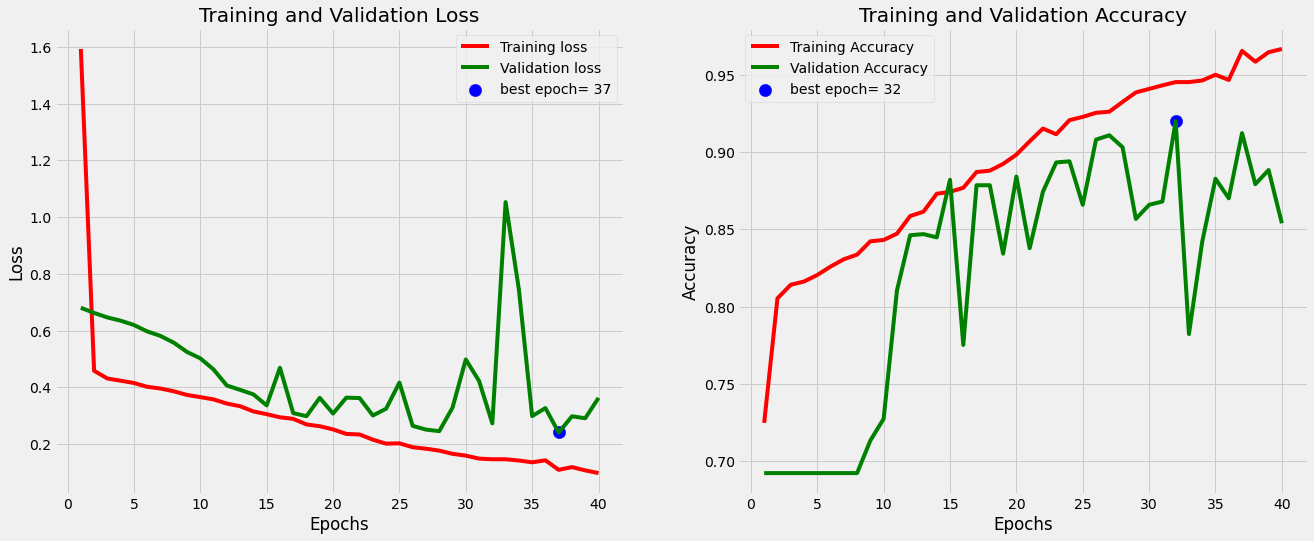

In [22]:
tr_plot(model_history,0)